In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats

def multi_plot(yss, preds):
    fig, ax = plt.subplots(2, 3, figsize=(22, 12))
    ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
    targets=[r"$log(v_{disk}/km/s)$", r"log($M_{cold}/M_{\odot}$)", r"log($SFR/M_{\odot}/yr$)"]
    targets=[r"$log(M_{*}/M_{\odot})$", r"log($M_{cold}/M_{\odot}$)", r"$log(Z_{gas})$", r"log($SFR/M_{\odot}/yr$)",
            r"log($SFR_{100}/M_{\odot}/yr$)", r"log($M_{BH}/M_{\odot}$)"]
    # target=r"$v_{disk}$"
    for i in range(len(targets)):
        target=targets[i]
        ys = yss[:,i]
        pred = preds[:,i]
        nullfmt = NullFormatter()         # no labels
        # definitions for the axes
        left, width = 0.15, 0.67
        bottom, height = 0.0, 0.75
        bottom_h = bottom +height
        left_h = left + width
        # rect_Cbar = [0, bottom, 0.1, height]
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.15]
        rect_histy = [left_h, bottom, 0.15+0.07, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

        # start with a rectangular Figure
        ax[i].set_axis_off()
        # axCbar = plt.axes(rect_Cbar)
        axHist = ax[i].inset_axes(rect_scatter)
        axHistx = ax[i].inset_axes(rect_histx)
        axHisty = ax[i].inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)

        bins=50
        l=0.0
        n_contour=4
        # the scatter plot:
        vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                    np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
        axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
        axHist.set(xlabel=f'SAM {target}',ylabel=f'GNN {target}')
        axHist.xaxis.label.set_fontsize(13)
        axHist.yaxis.label.set_fontsize(13)
        
        if i==0:
            axHist.legend(fontsize=12, loc='upper left')

        X, Y = X[0], Y.T[0]
        axHist.set_xlim((min(X), max(X)))
        axHist.set_ylim((min(Y), max(Y)))
        yhat=r'$\hat{y}$'

        #calculate metrics
        pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
        r2=r2_score(ys,pred)
        rho = np.corrcoef(ys,pred)[0,1]
        print('bias', np.mean(ys-pred))
        print('std', np.std(ys-pred))
        print('rho', rho)
        print('r2', r2)
        print('pct',pct)
        
        xt=0.45
        yt=0.2
        dy=0.07
        font = {'weight': 'normal',
            'size': 15}

        axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.2f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.2f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


        # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
        # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
        ys_kde = stats.gaussian_kde(ys, 0.1)
        pred_kde = stats.gaussian_kde(pred, 0.1)
        axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
        axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
        axHistx.legend(fontsize=12)
        axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.15), fontsize=12)

        font = {'family' : 'Serif',
                'weight' : 'normal',
                'size'   : 14}

        matplotlib.rc('font', **font)

        axHistx.set(title=f'SAM-GNN {target}', )

        axHistx.set_xlim(axHist.get_xlim())
        axHisty.set_ylim(axHist.get_ylim())

        divider = make_axes_locatable(axHisty)
        cax = divider.append_axes("right", size="15%", pad=0.18)
        divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

        # Plot vertical colorbar
        plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

In [3]:
# this is the full tree run
folder = 'results_final_Z_270322'
run = 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_msdgfh_1_2'

# folder = 'results_final_Z_300322'
# run = 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_mllteo'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
ys, pred = results['low_ys'], results['low_pred']
mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

Zy, Zpred = ys[:,2]+9, pred[:,2]+9
Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
sfr_ys, sfr_pred = ys[:,3], pred[:,3]
sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

In [4]:
# # this is the final halo run
# folder = 'results_finalhalo_Z_280322'
# run = 'Sage_vlarge_all_t_quantile_raw_rm_final_zvwpvm_1_2'
# pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
# results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
# config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
# ys, pred = results['low_ys'], results['low_pred']
# mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# # mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

# Zy, Zpred = ys[:,2]+9, pred[:,2]+9
# Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
# sfr_ys, sfr_pred = ys[:,3], pred[:,3]
# sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
# Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

In [5]:
np.corrcoef(Zpred, Coldpred), np.corrcoef(Zpred-Zy, Coldpred-Coldy)

(array([[1.        , 0.85291465],
        [0.85291465, 1.        ]]),
 array([[1.        , 0.69464096],
        [0.69464096, 1.        ]]))

In [6]:
np.corrcoef(Coldy, Coldpred), np.corrcoef(Zy,Zpred)

(array([[1.        , 0.95331536],
        [0.95331536, 1.        ]]),
 array([[1.        , 0.98463976],
        [0.98463976, 1.        ]]))

In [7]:
## this may not be the way to go
# Zy=np.log10((10**Zy)/(10**Coldy))
# Zpred=np.log10((10**Zpred)/(10**Coldpred))

# Zpred/=Coldpred
# Zy/=Coldy

In [8]:
Zy-=Coldy
Zpred-=Coldpred

In [9]:
np.corrcoef(Zpred, Coldpred), np.corrcoef(Zpred-Zy, Coldpred-Coldy)

(array([[1.       , 0.4673269],
        [0.4673269, 1.       ]]),
 array([[ 1.        , -0.41737178],
        [-0.41737178,  1.        ]]))

In [10]:
np.corrcoef(Coldy, Coldpred), np.corrcoef(Zy,Zpred)

(array([[1.        , 0.95331536],
        [0.95331536, 1.        ]]),
 array([[1.        , 0.97264417],
        [0.97264417, 1.        ]]))

In [11]:
# # this is the correlated run
# folder = 'results_final_Gauss4d_310122'
# run='Sage_vlarge_all_4t_z0.0_quantile_raw_seqqhl_5_6'
# pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
# results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
# config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
# ys, pred = results['low_ys'], results['low_pred']
# # mstar_ys, mstar_pred = ys[:,0], pred[:,0]
# vdisk_ys, vdisk_pred = ys[:,1], pred[:,1]
# sfr_ys, sfr_pred = ys[:,3], pred[:,3]

In [12]:
ys = np.vstack([ mstar_ys, Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
pred = np.vstack([mstar_pred, Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

bias 0.00021275837
std 0.07269396
rho 0.9969849269779993
r2 0.9939787761927356
pct 0.9807186678352322
bias -0.006112256
std 0.1622766
rho 0.9533153563918364
r2 0.9086030758276337
pct 0.8308501314636284
bias 0.0041905446
std 0.12532122
rho 0.9726441695327039
r2 0.9459046639577691
pct 0.9610683149591771
bias 0.0017956522
std 0.35535666
rho 0.935086789217517
r2 0.874378784247249
pct 0.5688915540384704
bias 0.022473007
std 0.34818822
rho 0.9375466063130855
r2 0.8784238542710784
pct 0.5669080677153006
bias -0.0007372683
std 0.12856358
rho 0.9740467195038096
r2 0.9487591542349237
pct 0.9083444808339868


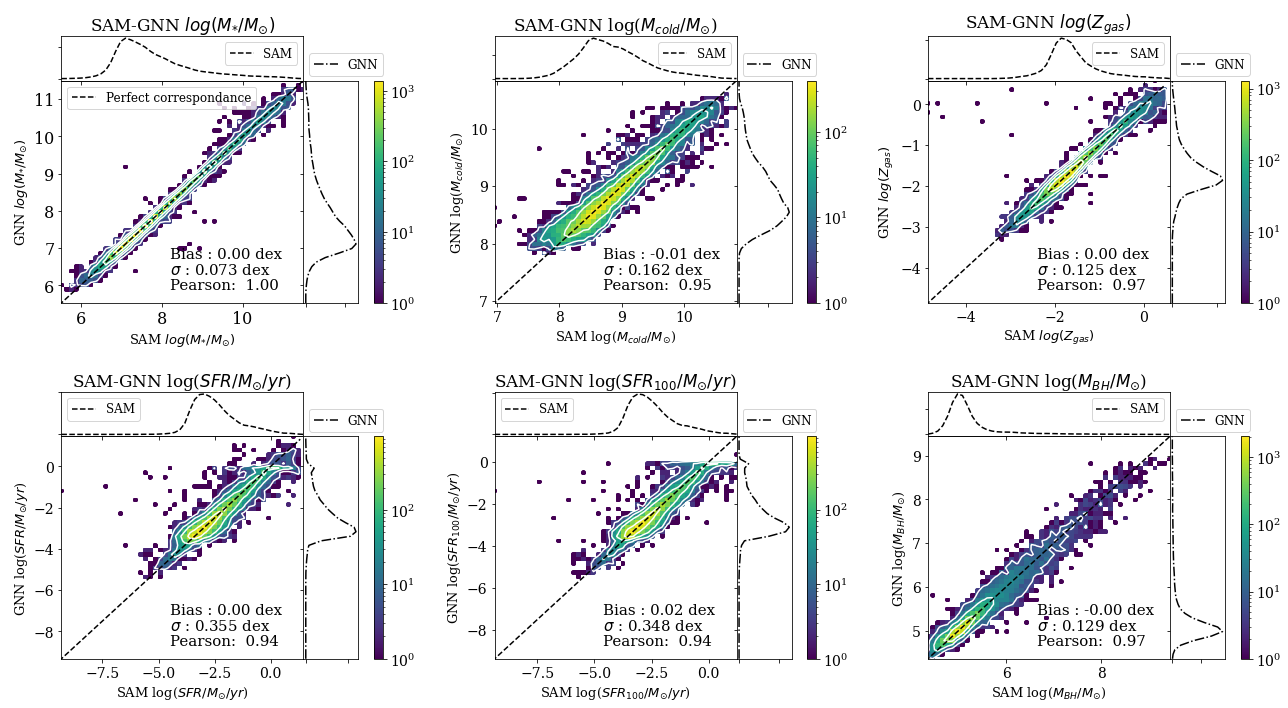

In [13]:
import matplotlib
font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
fig=multi_plot(ys, pred)
#0.16064388

In [14]:
# Zy, Zpred = ys[:,2], pred[:,2]
# Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
# Zy/=Coldy
# Zpred/=Coldpred

# # plt.hist2d()

In [15]:
# plt.hist2d((Zy*Coldy)**10/Coldy**, (Zpred*Coldpred)**10, bins=100);

In [16]:
# fig.savefig('../paper_figures/performance_others.png', bbox_inches='tight')

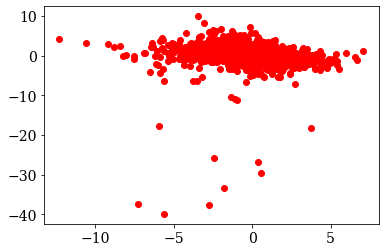

In [17]:
plt.plot((ys[:,1]-pred[:,1])/np.std((ys[:,1]-pred[:,1])),(ys[:,2]-pred[:,2])/np.std((ys[:,2]-pred[:,2])), 'ro') 
#corre
# plt.ylim(-0.3,0.2)

In [18]:
np.corrcoef(np.transpose(ys-pred))

array([[ 1.        ,  0.05145701,  0.2875132 ,  0.19346708,  0.19697201,
         0.099901  ],
       [ 0.05145701,  1.        , -0.41737178,  0.73757938,  0.75231507,
        -0.06637543],
       [ 0.2875132 , -0.41737178,  1.        , -0.03423662, -0.04519383,
        -0.01208083],
       [ 0.19346708,  0.73757938, -0.03423662,  1.        ,  0.93034466,
        -0.06529561],
       [ 0.19697201,  0.75231507, -0.04519383,  0.93034466,  1.        ,
        -0.06592073],
       [ 0.099901  , -0.06637543, -0.01208083, -0.06529561, -0.06592073,
         1.        ]])

In [19]:
ssfr_ys = sfr_ys-mstar_ys
ssfr_pred= sfr_pred-mstar_pred

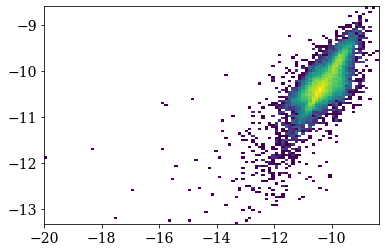

In [20]:
plt.hist2d(ssfr_ys, ssfr_pred, bins=100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis);

In [21]:
nbins=20
edges=np.linspace(8, max(mstar_ys),nbins)
centers=(edges[:-1]+edges[1:])/2
frac_ys=[]
for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<=mstar_ys,edges[i+1]>=mstar_ys)
    f = sum(ssfr_ys[mask]<-11)/sum(mask)
    frac_ys.append(f)
    
frac_ys=np.array(frac_ys)

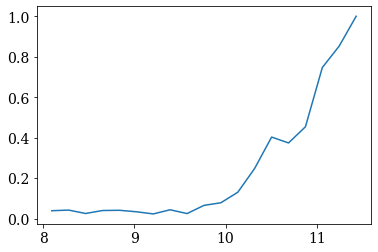

In [22]:
plt.plot(centers, frac_ys)

In [23]:
nbins=20
edges=np.linspace(8, max(mstar_pred),nbins)
centers=(edges[:-1]+edges[1:])/2
frac_pred=[]
for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<=mstar_pred,edges[i+1]>=mstar_pred)
    f = sum(ssfr_pred[mask]<-11)/sum(mask)
    frac_pred.append(f)
    
frac_pred=np.array(frac_pred)

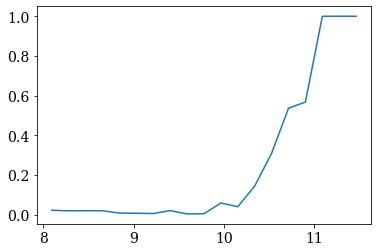

In [24]:
plt.plot(centers, frac_pred)